<a href="https://colab.research.google.com/github/Apara17/Apara17/blob/main/AI-based%20malware%20detection%20system-123-131_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1:Import Required Libraries & Mount Drive

In [ ]:
from google.colab import drive
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from flask import Flask, request, render_template
from werkzeug.utils import secure_filename

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# Step 2: Take Input Image from User and Convert .exe to Image and check if pretrained model exist then do the prediction else go for training the model

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

INPUT_EXE_PATH = "/content/drive/MyDrive/DATASET/RESEARCH PAPER DATASET IIT INDORE /Executables for testing"
OUTPUT_FOLDER = "/content/drive/MyDrive/Processed_Images_research"

def exe_to_grayscale(exe_path, output_folder):
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    try:
        print(f"Processing file: {exe_path}")

        # Read .exe file as binary
        with open(exe_path, 'rb') as f:
            byte_data = f.read()

        if not byte_data:
            print("Error: File is empty or unreadable.")
            return None

        file_size_mb = len(byte_data) / (1024 * 1024)  # Convert bytes to MB
        print(f"File size: {file_size_mb:.2f} MB")  # Print size in MB with 2 decimal places

        # Convert to grayscale image
        img_data = np.frombuffer(byte_data, dtype=np.uint8)
        img_size = int(np.ceil(np.sqrt(len(img_data))))
        img_data = np.pad(img_data, (0, img_size**2 - len(img_data)), 'constant')
        img_data = img_data.reshape((img_size, img_size))

        # Save image
        img_name = os.path.basename(exe_path).replace('.exe', '.png')
        img_path = os.path.join(output_folder, img_name)
        success = cv2.imwrite(img_path, img_data)

        if success:
            print(f"✅ Image saved at: {img_path}")

            # Display the image
            plt.imshow(img_data, cmap='gray')
            plt.title("Generated Grayscale Image")
            plt.axis("off")
            plt.show()
        else:
            print("❌ Error: Image could not be saved.")
            return None

        return img_path

    except Exception as e:
        print(f"Error processing file: {e}")
        return None

# Run the function and check output
exe_to_grayscale(INPUT_EXE_PATH, OUTPUT_FOLDER)




Processing file: /content/drive/MyDrive/DATASET/RESEARCH PAPER DATASET IIT INDORE /Executables for testing
Error processing file: [Errno 21] Is a directory: '/content/drive/MyDrive/DATASET/RESEARCH PAPER DATASET IIT INDORE /Executables for testing'


In [ ]:
from tensorflow.keras.models import load_model
import os

MODEL_PATH = "/content/drive/MyDrive/Malware_HybridViT_Model.h5"

if os.path.exists(MODEL_PATH):
    print("✅ trained model found! Loading model...")

    try:
        # Load model properly
        model = load_model(MODEL_PATH, compile=False)  # Avoids metric issues

        # Recompile with correct settings
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        print("✅ Model loaded successfully and compiled!")

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("🔄 You may need to re-train and save the model again.")
        model = None

else:
    print("❌ No pre-trained model found! Train and save the model again.")
    model = None  # Ensure model variable exists


✅ trained model found! Loading model...
✅ Model loaded successfully and compiled!


In [ ]:
import cv2
import numpy as np

# Known malware classes from your training dataset
MALWARE_CLASSES = [
    "Agent.FYI", "Allaple.A", "Allaple.L", "Barys", "Cerber", "Connectix",
    "Fakerean", "Hlux.K", "Kelihos_ver1", "Kelihos_ver3", "Kryptik",
    "Lolyda.AA1", "Lolyda.AA2", "Lolyda.AA3", "Lolyda.AT", "Obfuscator.AD",
    "Renos", "Simda", "Tracur", "Vobfus", "Vundo", "Winwebsec", "Zbot", "Zeus", "Zeroaccess"
]

CONFIDENCE_THRESHOLD = 0.75  # Anything below this is considered unknown/safe

def predict_malware(processed_image_path, model, class_names):
    if not os.path.exists(processed_image_path):
        print("❌ Error: Processed image not found.")
        return

    try:
        # Load the grayscale image
        img = cv2.imread(processed_image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))  # Resize for model input

        # Convert grayscale to RGB (since model expects RGB)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img = img.reshape(1, 224, 224, 3) / 255.0  # Normalize

        # Predict with the trained model
        prediction = model.predict(img)[0]  # Get class probabilities
        predicted_class = np.argmax(prediction)  # Get the highest probability class
        confidence = np.max(prediction)  # Get confidence score

        # Get class label from trained dataset
        predicted_label = class_names[predicted_class] if predicted_class < len(class_names) else "Unknown"

        # Apply the confidence threshold
        if confidence < CONFIDENCE_THRESHOLD:
            result = "🟢 SAFE OR UNKNOWN FILE"
        else:
            result = "🔴 MALWARE DETECTED"

        print(f"Prediction: {result} (Class: {predicted_label}, Confidence: {confidence:.4f})")

    except Exception as e:
        print(f"❌ Error during prediction: {e}")

# Example Usage
PROCESSED_IMAGE_PATH = "/content/drive/MyDrive/DATASET/MalwareImages Dataset/test/Skintrim.N/0089b5c2a9581a52b6ca57f9c6612a12.png"

# Ensure class names are available (from training dataset)
class_names = MALWARE_CLASSES  # Using the same malware classes list

predict_malware(PROCESSED_IMAGE_PATH, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Prediction: 🔴 MALWARE DETECTED (Class: Lolyda.AT, Confidence: 0.9335)


In [ ]:
import cv2
import numpy as np

def predict_malware(processed_image_path, model):
    if not os.path.exists(processed_image_path):
        print("❌ Error: Processed image not found.")
        return

    try:
        # Load the grayscale image
        img = cv2.imread(processed_image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))  # Resize to match model input

        # Convert grayscale to RGB by duplicating channels
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel format

        img = img.reshape(1, 224, 224, 3) / 255.0  # Normalize and ensure correct shape

        # Predict with the trained model
        prediction = model.predict(img)[0]  # Get the predicted class probabilities
        predicted_class = np.argmax(prediction)  # Get the highest probability class
        confidence = np.max(prediction)  # Get confidence score

        print(f"Prediction: Class {predicted_class} (Confidence: {confidence:.4f})")

    except Exception as e:
        print(f"❌ Error during prediction: {e}")

# Example Usage
PROCESSED_IMAGE_PATH = "/content/drive/MyDrive/Processed_Images_research/PoP8Setup.png"
predict_malware(PROCESSED_IMAGE_PATH, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction: Class 14 (Confidence: 0.9561)


# Step 3:Taking Dataset from Developer and converting .exe to grey scale image including (Data preprocess and visualisation)

Unzip all the .exe files

In [ ]:
import os
import zipfile

# Path to your dataset directory
dataset_path = "/content/drive/MyDrive/DATASET/RESEARCH PAPER DATASET IIT INDORE /Executables for testing"
save_path = "/content/drive/MyDrive/sharmila-import"  # New folder for extracted files

# Ensure save directory exists
os.makedirs(save_path, exist_ok=True)

def get_password(folder):
    """Retrieve password from password.txt if available, else return default."""
    password_file = os.path.join(folder, "password.txt")
    if os.path.exists(password_file):
        with open(password_file, "r") as f:
            return f.read().strip().encode()  # Convert to bytes
    return b"infected"  # Default password

def extract_zip_files(dataset_path, save_path):
    """Extract all ZIP files in dataset_path and save them to save_path."""
    for root, _, files in os.walk(dataset_path):
        password = get_password(root)  # Get password for current folder

        for file in files:
            if file.endswith(".zip"):
                zip_path = os.path.join(root, file)
                extract_folder = os.path.join(save_path, os.path.relpath(root, dataset_path))  # Maintain folder structure

                os.makedirs(extract_folder, exist_ok=True)  # Ensure directory exists

                try:
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        zip_ref.extractall(extract_folder, pwd=password)
                        print(f"Extracted: {zip_path} → {extract_folder}")

                except RuntimeError:
                    print(f"Wrong Password: {zip_path} (Try checking password.txt manually)")
                except zipfile.BadZipFile:
                    print(f"Corrupt ZIP: {zip_path}")

# Run the extraction
extract_zip_files(dataset_path, save_path)


Convert .exe to Greyscale Image

In [ ]:
import os
import numpy as np
import cv2

# Paths
DATASET_PATH = "/content/drive/MyDrive/sharmila-import"  # Extracted dataset location
IMAGE_FOLDER = "/content/drive/MyDrive/GREYSCALERESEARCH"  # New folder for grayscale images

# Ensure output folder exists
os.makedirs(IMAGE_FOLDER, exist_ok=True)

def exe_to_grayscale(exe_path, output_folder):
    """Convert .exe file to grayscale image and save it."""
    try:
        print(f"Processing: {exe_path}")

        # Read .exe file as binary
        with open(exe_path, 'rb') as f:
            byte_data = f.read()

        if not byte_data:
            print("❌ Error: File is empty or unreadable.")
            return None

        # Convert bytes to grayscale image
        img_data = np.frombuffer(byte_data, dtype=np.uint8)
        img_size = int(np.ceil(np.sqrt(len(img_data))))  # Determine square shape
        img_data = np.pad(img_data, (0, img_size**2 - len(img_data)), 'constant')  # Pad if needed
        img_data = img_data.reshape((img_size, img_size))  # Reshape to 2D

        # Save image
        img_name = os.path.basename(exe_path).replace('.exe', '.png')
        img_path = os.path.join(output_folder, img_name)
        cv2.imwrite(img_path, img_data)

        print(f"✅ Image saved: {img_path}")

        return img_path

    except Exception as e:
        print(f"❌ Error processing {exe_path}: {e}")
        return None

# Search and process .exe files
exe_files = []
for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".exe"):
            exe_files.append(os.path.join(root, file))

if not exe_files:
    print("❌ No .exe files found in dataset.")
else:
    print(f"✅ Found {len(exe_files)} .exe files. Processing...")

    # Convert each .exe file to grayscale image
    for exe_file in exe_files:
        exe_to_grayscale(exe_file, IMAGE_FOLDER)

    print("🎉 All .exe files converted successfully!")

    # Count number of images converted
    num_images = len([f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.png')])
    print(f"📸 Total grayscale images saved: {num_images}")


❌ No .exe files found in dataset.


Data Augmentation

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from tqdm import tqdm

# Paths
INPUT_FOLDER = "/content/drive/MyDrive/GREYSCALERESEARCH"  # Original grayscale images
OUTPUT_FOLDER = "/content/drive/MyDrive/GREYSCALEZOO_AUGMENTED"  # Augmented dataset

# Ensure output folder exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=360, p=0.7),
    A.RandomBrightnessContrast(p=0.6),
    A.GaussNoise(p=0.5),
    A.GaussianBlur(p=0.4),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5)
])

# Process images
image_files = [f for f in os.listdir(INPUT_FOLDER) if f.endswith('.png')]
total_images = len(image_files)

if total_images == 0:
    print("❌ No images found in the folder.")
else:
    print(f"✅ Found {total_images} images. Applying augmentation...")

    # Augment each image 10 times to increase dataset size
    AUGMENTATIONS_PER_IMAGE = 10

    for img_file in tqdm(image_files):
        img_path = os.path.join(INPUT_FOLDER, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        for i in range(AUGMENTATIONS_PER_IMAGE):
            augmented = transform(image=img)['image']
            aug_img_name = img_file.replace('.png', f'_aug{i}.png')
            aug_img_path = os.path.join(OUTPUT_FOLDER, aug_img_name)
            cv2.imwrite(aug_img_path, augmented)

    # Count final dataset size
    final_count = len([f for f in os.listdir(OUTPUT_FOLDER) if f.endswith('.png')])
    print(f"🎉 Augmentation complete! Total images in dataset: {final_count}")


❌ No images found in the folder.


<ipython-input-28-1683c75b893f>:22: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


Data Visualization

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

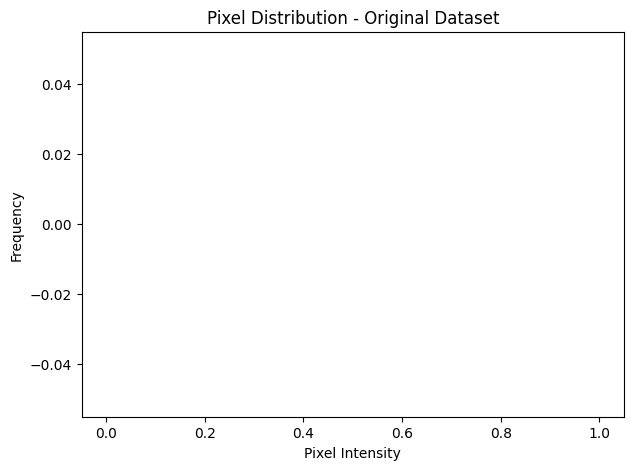

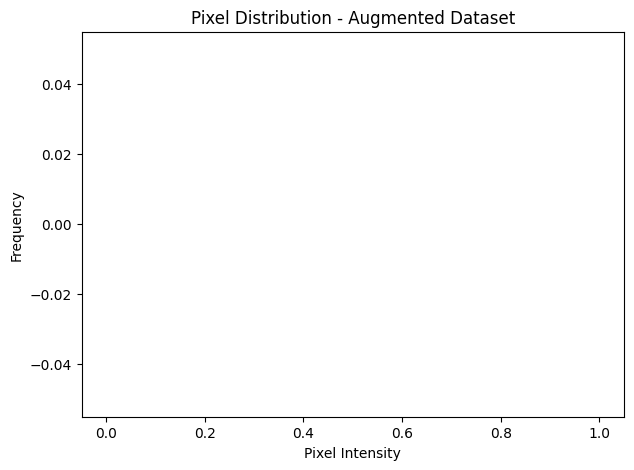

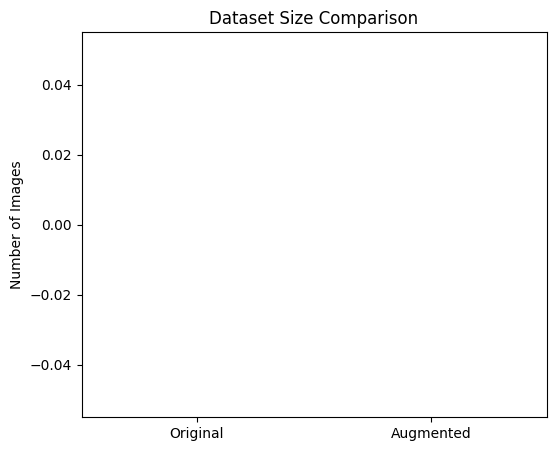

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Paths
ORIGINAL_FOLDER = "/content/drive/MyDrive/GREYSCALERESEARCH"
AUGMENTED_FOLDER = "/content/drive/MyDrive/GREYSCALEZOO_AUGMENTED"

# Get image lists
original_images = [f for f in os.listdir(ORIGINAL_FOLDER) if f.endswith('.png')]
augmented_images = [f for f in os.listdir(AUGMENTED_FOLDER) if f.endswith('.png')]

# Function to display images
def show_images(image_paths, title, folder):
    plt.figure(figsize=(10, 5))
    for i, img_file in enumerate(random.sample(image_paths, min(5, len(image_paths)))):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

# Show sample images
show_images(original_images, "Original Dataset Samples", ORIGINAL_FOLDER)
show_images(augmented_images, "Augmented Dataset Samples", AUGMENTED_FOLDER)

# Function to plot histogram
def plot_histogram(image_paths, title, folder):
    pixel_values = []
    for img_file in random.sample(image_paths, min(50, len(image_paths))):  # Sample 50 images
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        pixel_values.extend(img.flatten())

    plt.figure(figsize=(7, 5))
    plt.hist(pixel_values, bins=256, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Plot histograms
plot_histogram(original_images, "Pixel Distribution - Original Dataset", ORIGINAL_FOLDER)
plot_histogram(augmented_images, "Pixel Distribution - Augmented Dataset", AUGMENTED_FOLDER)

# Bar chart for dataset sizes
plt.figure(figsize=(6, 5))
plt.bar(["Original", "Augmented"], [len(original_images), len(augmented_images)], color=["blue", "green"])
plt.ylabel("Number of Images")
plt.title("Dataset Size Comparison")
plt.show()


# Step 4: Model Training

In [ ]:

# Define paths
train_dir = '/content/drive/MyDrive/DATASET/MalwareImages Dataset/train'
valid_dir = '/content/drive/MyDrive/DATASET/MalwareImages Dataset/val'
test_dir = '/content/drive/MyDrive/DATASET/MalwareImages Dataset/test'

In [ ]:
folders = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]

In [ ]:

# Lists to hold data and labels
train_data, train_labels = [], []
valid_data, valid_labels = [], []
test_data, test_labels = [], []



In [ ]:
# Function to read data and labels from directories
def read_data(folder):
    data, labels = [], []
    for label in folders:
        path = os.path.join(folder, label)
        if os.path.isdir(path):  # Check if the path is a directory
            folder_data = os.listdir(path)
            for image_path in folder_data:
                img_path = os.path.join(path, image_path)
                img = cv2.imread(img_path)
                if img is not None:  # Check if the image was read correctly
                    img = cv2.resize(img, (224, 224))
                    data.append(np.array(img))
                    labels.append(label)
    return data, labels

In [ ]:
train_data, train_labels = read_data(train_dir)
valid_data, valid_labels = read_data(valid_dir)
test_data, test_labels = read_data(test_dir)

In [ ]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [ ]:
print("Train Size: ", train_data.shape[0])
print("valid Size: ", valid_data.shape[0])
print("Test Size: ", test_data.shape[0])


Train Size:  0
valid Size:  0
Test Size:  0


In [ ]:
import numpy as np
import pandas as pd
train_df = pd.DataFrame({"train": train_labels})
valid_df = pd.DataFrame({"valid": valid_labels})
test_df = pd.DataFrame({"test": test_labels})

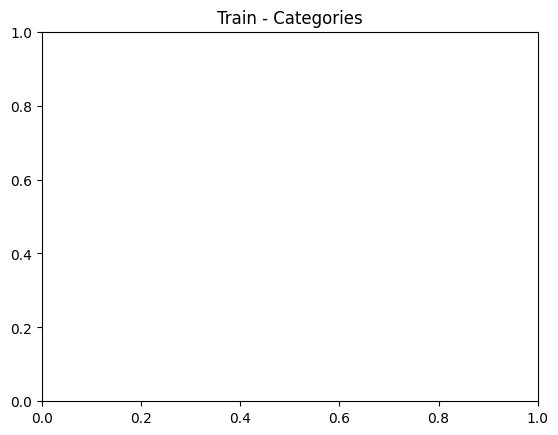

In [ ]:
ax = sns.countplot(y="train", order=train_df["train"].value_counts().index, data=train_df)
ax.set_title("Train - Categories")
for container in ax.containers:
    ax.bar_label(container)

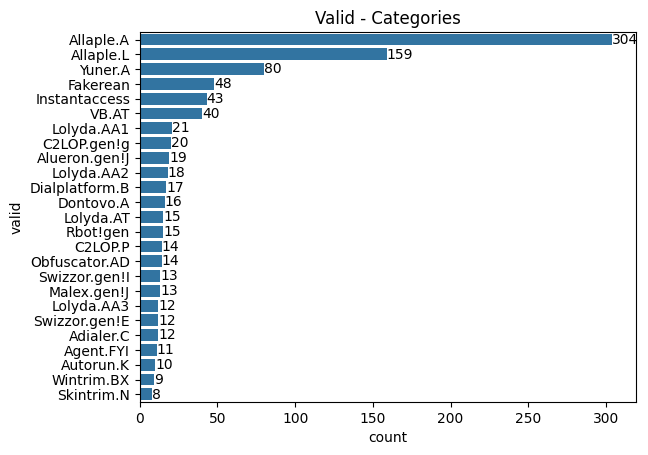

In [ ]:
ax = sns.countplot(y="valid", order=valid_df["valid"].value_counts().index, data=valid_df)
ax.set_title("Valid - Categories")
for container in ax.containers:
    ax.bar_label(container)

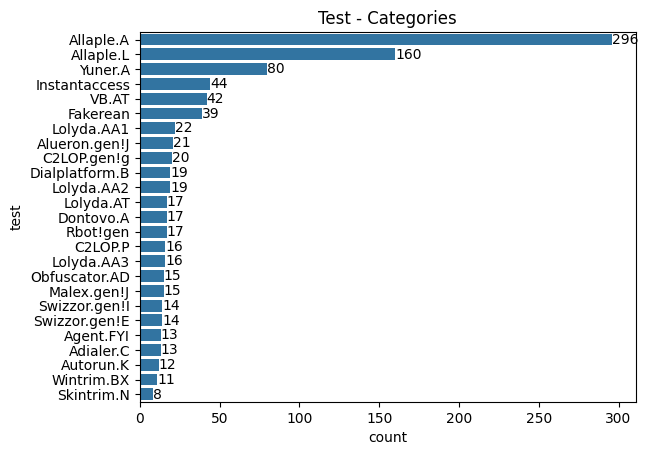

In [ ]:
ax = sns.countplot(y="test", order=test_df["test"].value_counts().index, data=test_df)
ax.set_title("Test - Categories")
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
def visualize_df(df: np.ndarray):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img = df[a]
            ax.imshow(img, cmap="gray")
            ax.set_title(train_labels[a])
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

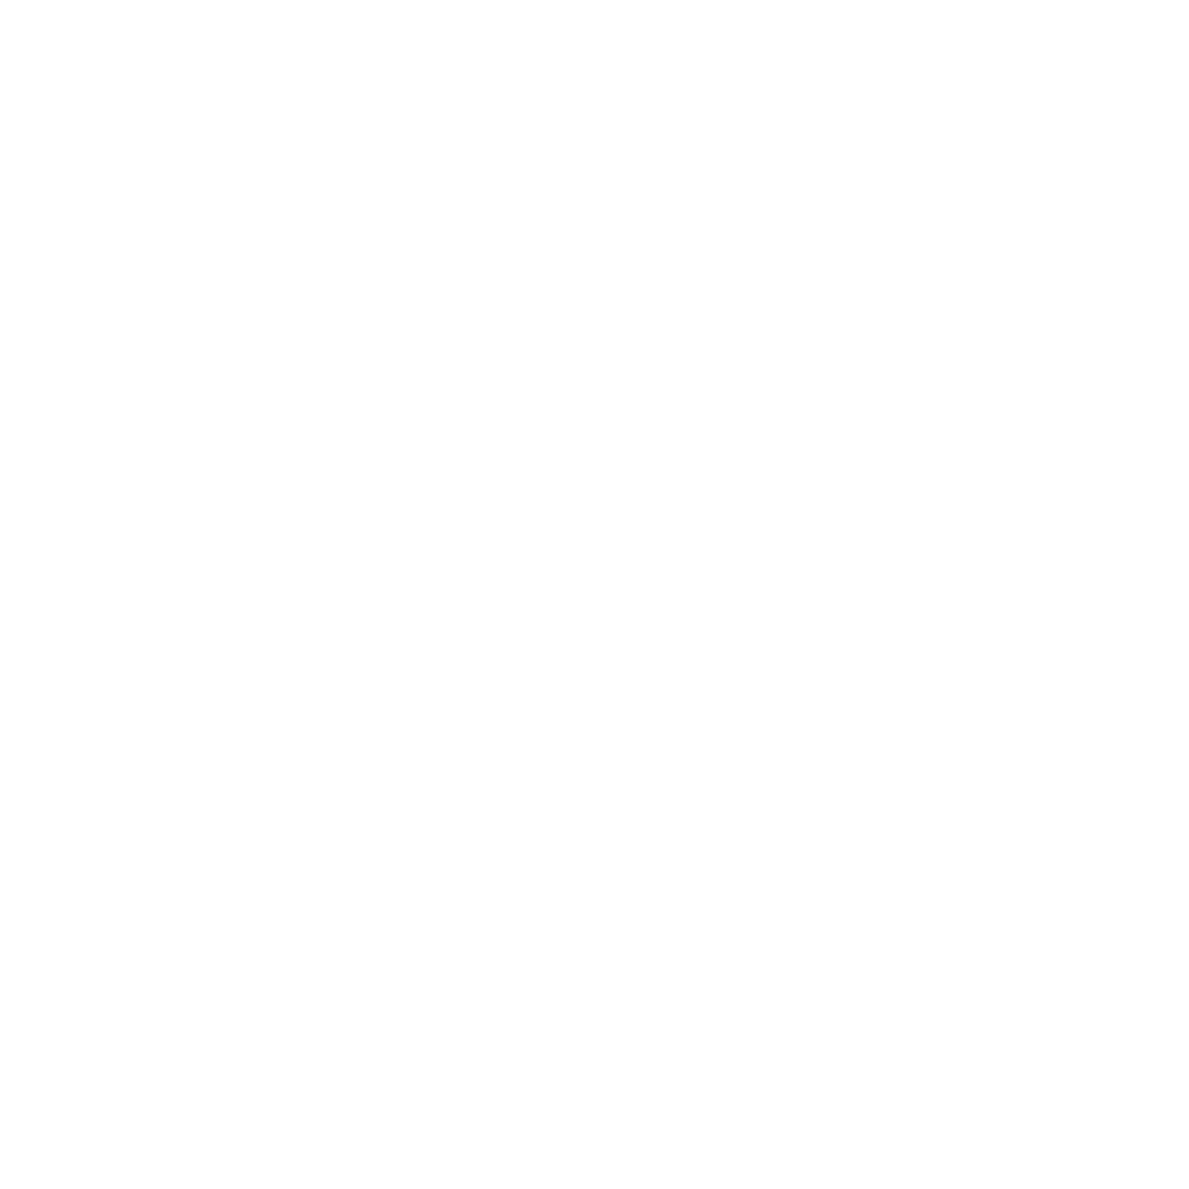

In [ ]:
visualize_df(train_data)

In [ ]:
rand_train = np.arange(7459)
rand_valid = np.arange(923)
rand_test = np.arange(957)


In [ ]:
train_data = train_data[rand_train]
train_labels = train_labels[rand_train]

valid_data = valid_data[rand_valid]
valid_labels = valid_labels[rand_valid]

test_data = test_data[rand_test]
test_labels = test_labels[rand_test]

In [ ]:
# Hybrid Vision Transformer (ViT) Model for Malware Analysis

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import numpy as np
import os

# Define paths
train_dir = '/content/drive/MyDrive/DATASET/MalwareImages Dataset/train'
valid_dir = '/content/drive/MyDrive/DATASET/MalwareImages Dataset/val'
test_dir = '/content/drive/MyDrive/DATASET/MalwareImages Dataset/test'

# Parameters
image_size = 224
batch_size = 32

# Load datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    label_mode="categorical"
)

valid_dataset = image_dataset_from_directory(
    valid_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    label_mode="categorical"
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    label_mode="categorical"
)

# Extract class names
class_names = train_dataset.class_names

# AUTOTUNE for performance optimization
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Determine number of classes
num_classes = len(class_names)

# Vision Transformer Block
def transformer_block(inputs, num_heads, key_dim, feed_forward_units, dropout_rate):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout_rate)(x, x)
    x = layers.Add()([attention_output, inputs])
    x_ffn = layers.LayerNormalization(epsilon=1e-6)(x)
    x_ffn = layers.Dense(feed_forward_units, activation='relu')(x_ffn)
    x_ffn = layers.Dropout(dropout_rate)(x_ffn)
    x_ffn = layers.Dense(inputs.shape[-1])(x_ffn)
    return layers.Add()([x, x_ffn])

# Hybrid ViT Model
def create_hybrid_vit_model(image_size, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
    base_model.trainable = False

    inputs = layers.Input(shape=(image_size, image_size, 3))
    features = base_model(inputs)
    patches = layers.Reshape((-1, features.shape[-1]))(features)

    x = patches
    for _ in range(4):
        x = transformer_block(x, num_heads=8, key_dim=64, feed_forward_units=128, dropout_rate=0.1)

    global_avg_pool = layers.GlobalAveragePooling1D()(x)
    dense_layer = layers.Dense(128, activation='relu')(global_avg_pool)
    dropout_layer = layers.Dropout(0.5)(dense_layer)
    outputs = layers.Dense(num_classes, activation='softmax')(dropout_layer)

    return models.Model(inputs, outputs)

# Create Hybrid ViT Model
hybrid_vit_model = create_hybrid_vit_model(image_size=image_size, num_classes=num_classes)

# Compile Model
hybrid_vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = hybrid_vit_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=5,
    callbacks=[early_stopping]
)

# Evaluate Model
test_loss, test_accuracy = hybrid_vit_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")




Found 7585 files belonging to 25 classes.
Found 943 files belonging to 25 classes.
Found 960 files belonging to 25 classes.
Epoch 1/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 115s 343ms/step - accuracy: 0.7671 - loss: 0.9442 - val_accuracy: 0.9523 - val_loss: 0.1796
Epoch 2/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 97s 217ms/step - accuracy: 0.9512 - loss: 0.1767 - val_accuracy: 0.9799 - val_loss: 0.0546
Epoch 3/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 51s 215ms/step - accuracy: 0.9712 - loss: 0.0971 - val_accuracy: 0.9809 - val_loss: 0.0593
Epoch 4/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.9769 - loss: 0.0798 - val_accuracy: 0.9788 - val_loss: 0.0731
Epoch 5/5
238/238 ━━━━━━━━━━━━━━━━━━━━ 51s 214ms/step - accuracy: 0.9797 - loss: 0.0704 - val_accuracy: 0.9767 - val_loss: 0.0657
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9851 - loss: 0.0362
Test Loss: 0.04878254979848862, Test Accuracy: 0.981249988079071


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

# Define model save path in .h5 format
model_save_path_h5 = "/content/drive/MyDrive/Malware_HybridViT_Model.h5"

# Save model in HDF5 (.h5) format
hybrid_vit_model.save(model_save_path_h5, save_format='h5')

# Print saved model path
print(f"Model successfully saved at: {model_save_path_h5}")


Model successfully saved at: /content/drive/MyDrive/Malware_HybridViT_Model.h5


In [ ]:
import os
import warnings
import tensorflow as tf
from tensorflow.keras.models import save_model

warnings.filterwarnings("ignore")  # Suppress warnings

# Define model save path in .h5 format
model_save_path_h5 = "/content/drive/MyDrive/Malware_HybridViT_Model.h5"

# Ensure the directory exists
os.makedirs(os.path.dirname(model_save_path_h5), exist_ok=True)

# Save the model properly
hybrid_vit_model.save(model_save_path_h5)

# Verify model file exists
if os.path.exists(model_save_path_h5):
    print(f"✅ Model successfully saved at: {model_save_path_h5}")
else:
    print("❌ Error: Model was NOT saved properly!")

✅ Model successfully saved at: /content/drive/MyDrive/Malware_HybridViT_Model.h5


# Step 5: Model evaluation

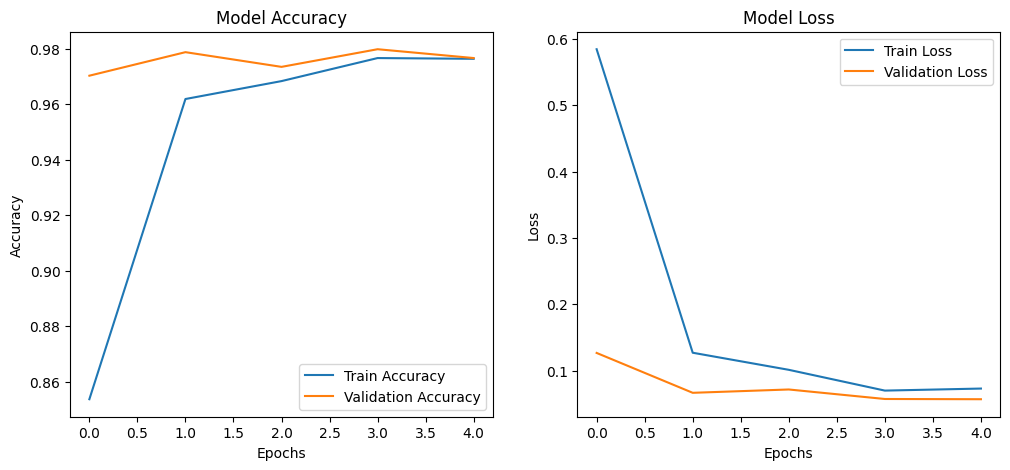

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

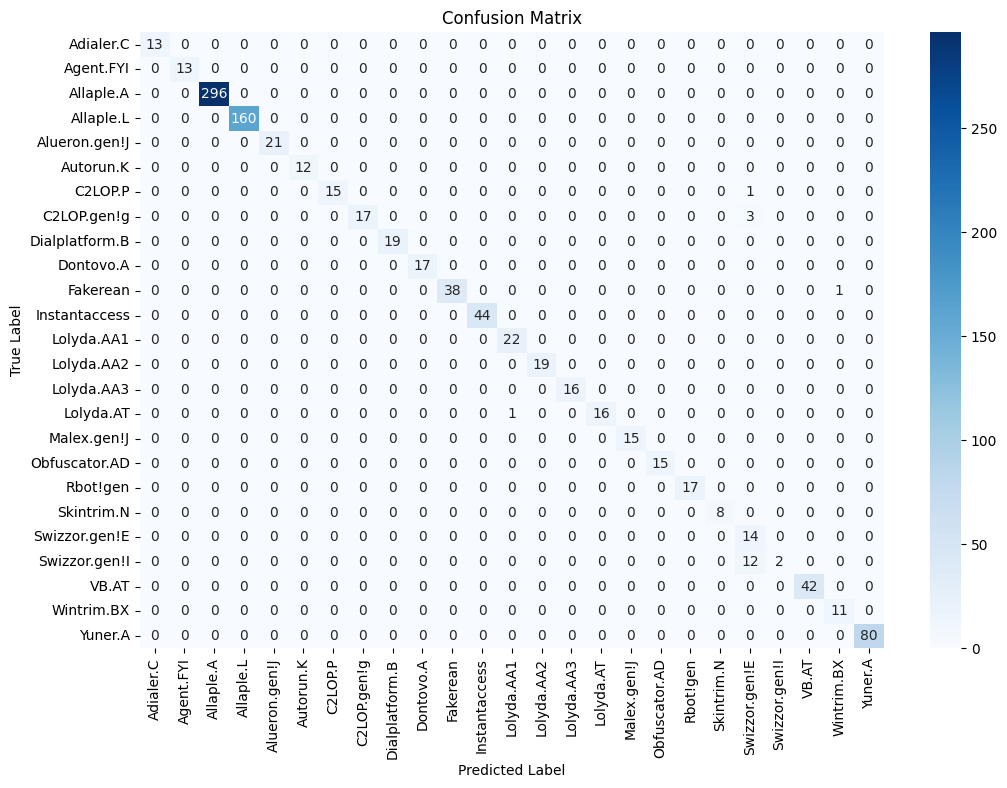

Classification Report:
                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        13
     Agent.FYI       1.00      1.00      1.00        13
     Allaple.A       1.00      1.00      1.00       296
     Allaple.L       1.00      1.00      1.00       160
 Alueron.gen!J       1.00      1.00      1.00        21
     Autorun.K       1.00      1.00      1.00        12
       C2LOP.P       1.00      0.94      0.97        16
   C2LOP.gen!g       1.00      0.85      0.92        20
Dialplatform.B       1.00      1.00      1.00        19
     Dontovo.A       1.00      1.00      1.00        17
      Fakerean       1.00      0.97      0.99        39
 Instantaccess       1.00      1.00      1.00        44
    Lolyda.AA1       0.96      1.00      0.98        22
    Lolyda.AA2       1.00      1.00      1.00        19
    Lolyda.AA3       1.00      1.00      1.00        16
     Lolyda.AT       1.00      0.94      0.97        17
   Malex.gen!J       1.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Plot Accuracy & Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

# Call function to plot accuracy/loss
plot_training_history(history)

# Get predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = hybrid_vit_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step


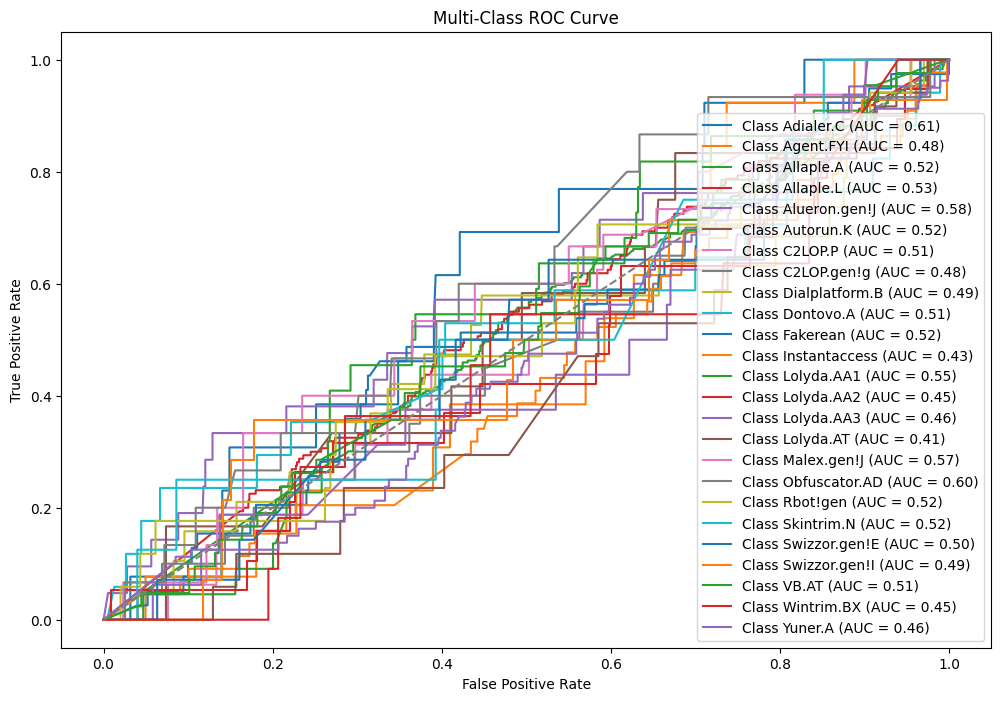

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Get model predictions (probabilities)
y_pred_prob = hybrid_vit_model.predict(test_dataset)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()
